In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
from io import BytesIO
from zipfile import ZipFile

from datetime import datetime

import numpy as np
import pandas as pd
import statsmodels.api as sm

%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

from IPython.display import display, Markdown

In [3]:
base_folder = 'C:/Users/jjd/Desktop/ForexVolume'
clsh_file = os.path.join(base_folder, 'clsForexVolJan2014.csv')
FXCM_DATA_FOLDER =  os.path.join(base_folder, 'forex/fxcm/hour')

In [4]:
# List of pairs with FXCM volume data
pairs = ['EURUSD', 'USDJPY', 'GBPUSD', 'USDCHF', 'EURCHF',
         'AUDUSD', 'USDCAD', 'NZDUSD', 'EURGBP', 'EURJPY',
         'GBPJPY', 'EURAUD', 'EURCAD', 'AUDJPY']

In [5]:
def get_fxcm_volume_data(pair):
    """
    Returns a DataFrame with the FXCM Real Volume generted by the 
    Lean Toolbox project.
    """
    pair = pair.lower()
    file_name = os.path.join(FXCM_DATA_FOLDER, pair + '_volume.zip')
    file_handler = open(file_name, 'rb') 
    zip_file = ZipFile(file_handler)
    csv_filename = zip_file.namelist()[0]
    data = BytesIO(zip_file.read(csv_filename))
    return pd.read_csv(data, header=None, index_col=0, usecols=range(2),
                       names=['Time', pair.upper() + '_FXCM'])

In [6]:
def get_clsh_volume_data(pairs):
    """
    Returns a DataFrame with the CLSH sample volume data.
    """
    clsh_data = pd.read_csv(clsh_file, index_col=0, parse_dates=True)
    time_based_index = []
    for day in clsh_data.Date.unique():
        for hour in clsh_data.columns[1:]:
            time_based_index.append(datetime.strptime(day + ' ' + hour,
                                                      '%Y-%m-%d %H:%M'))
    
    volume_df = pd.DataFrame(index=time_based_index)
    for pair in pairs:
        pair.upper()
        volume_data = clsh_data.loc[pair + '_SPT_VOL',:]
        volume_data.set_index('Date', drop=True, inplace=True)
        volume_df[pair + '_CLSH'] = volume_data.stack().values
    return volume_df

In [7]:
def standardize(df):
    return (df - df.mean()) / df.std()

In [8]:
clsh_volume = get_clsh_volume_data(pairs)

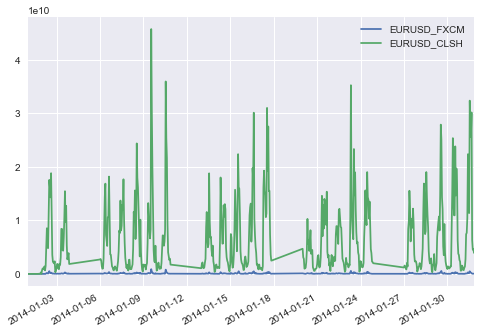

In [15]:
pair = 'EURUSD'
fxcm = get_fxcm_volume_data(pair)
clsh = clsh_volume.get(pair + '_CLSH')
df = fxcm.join(clsh, how='inner')
df.plot()

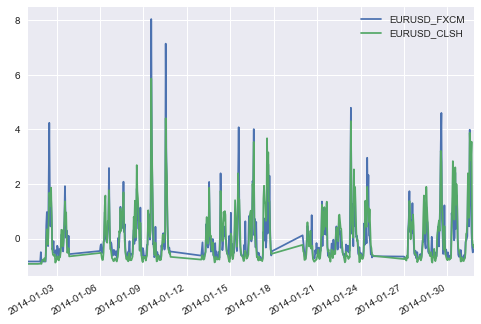

In [16]:
df = standardize(df)
df.plot()

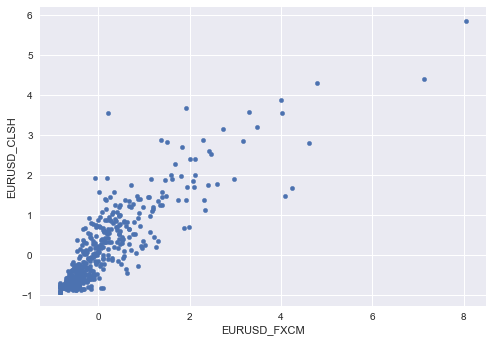

In [17]:
df.plot(kind='scatter', x=pair + '_FXCM', y=pair + '_CLSH')

In [18]:
x = sm.add_constant(df.EURUSD_FXCM, prepend=False)
y = df.EURUSD_CLSH
mod = sm.OLS(y, x)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            EURUSD_CLSH   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     1775.
Date:                Fri, 11 Aug 2017   Prob (F-statistic):          1.16e-172
Time:                        11:47:47   Log-Likelihood:                -373.03
No. Observations:                 541   AIC:                             750.1
Df Residuals:                     539   BIC:                             758.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
EURUSD_FXCM     0.8758      0.021     42.130      

In [31]:
r_squared = []
coef = []
significance = []

for pair in pairs:
    fxcm = get_fxcm_volume_data(pair)
    clsh = clsh_volume.get(pair + '_CLSH')
    df = fxcm.join(clsh, how='inner')
    df = standardize(df)
    x_var = pair + '_FXCM'
    y_var = pair + '_CLSH'
    # df.plot(kind='scatter', x=x_var, y=y_var);
    x = sm.add_constant(df.get(x_var), prepend=False)
    y = df.get(y_var)
    mod = sm.OLS(y, x)
    res = mod.fit()
    r_squared.append(res.rsquared)
    coef.append(res.params[0])
    significance.append('{0}'.format(res.pvalues[0] < 0.01))
    # print(res.summary())

regressions_results = pd.DataFrame({'Coefficient':coef, 'Significance at 99%':significance, 'R Squared': r_squared},
                                   index=pairs)

In [37]:
regressions_results

,Coefficient,R Squared,Significance at 99%
EURUSD,0.875820,0.767061,True
USDJPY,0.906553,0.821839,True
GBPUSD,0.873854,0.763621,True
USDCHF,0.780793,0.609638,True
EURCHF,0.685604,0.470052,True
AUDUSD,0.832147,0.692469,True
USDCAD,0.659832,0.435379,True
NZDUSD,0.588424,0.346243,True
EURGBP,0.409120,0.167379,True
EURJPY,0.791885,0.627083,True


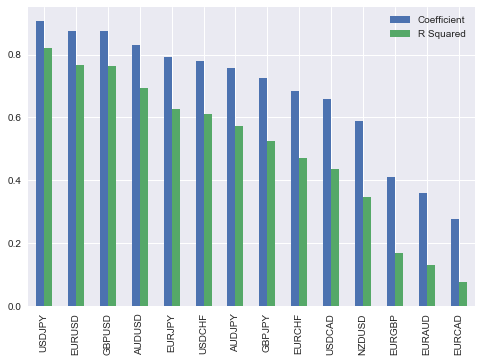

In [41]:
regressions_results.sort_values('R Squared', ascending=False).plot(kind='bar')